In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

In [2]:
url_inv = "https://open.canada.ca/data/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c/resource/3acf79c0-a5f5-4d9a-a30d-fb5ceba4b60a/download/service_inventory.csv"
url_std = "https://open.canada.ca/data/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c/resource/272143a7-533e-42a1-b72d-622116474a21/download/service_standards.csv"

In [3]:
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
#df_inv = pd.read_csv(url_inv)
df_inv = pd.read_csv('service_inventory.csv')

In [ ]:
df_inv.head()

In [ ]:
df_inv.describe()

In [4]:
df_inv.columns

Index(['Unnamed: 0', 'fiscal_yr', 'service_id', 'service_name_en',
       'service_name_fr', 'department_name_en', 'department_name_fr',
       'external_internal', 'service_type', 'special_designations',
       'service_description_en', 'service_description_fr', 'service_url_en',
       'service_url_fr', 'program_name_en', 'program_name_fr', 'last_GBA',
       'client_target_groups', 'info_service', 'service_fee',
       'cra_business_number', 'use_of_sin', 'service_channels',
       'online_applications', 'web_visits_info_service', 'calls_received',
       'in_person_applications', 'postal_mail_applications',
       'other_applications', 'e_registration', 'e_authentication',
       'e_application', 'e_decision', 'e_issuance', 'e_feedback',
       'client_feedback', 'special_remarks_en', 'special_remarks_fr'],
      dtype='object')

# Data Cleanup

## Numeric columns

In [5]:
#Convert object columns to numeric data type.
numeric_columns = ['web_visits_info_service', 'calls_received', 'online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications']
for col in numeric_columns:
    df_inv[col] = pd.to_numeric(df_inv[col], errors = 'coerce')

In [6]:
#Sum total applications
applications=['online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications']
df_inv["total_applications"]=df_inv[applications].sum(axis=1)

## External_internal

Much of this is copied from Dia's notebook

In [7]:
df_inv.external_internal.value_counts()

extern                      1461
enterprise                   220
extern,enterprise            136
extern,intern                 18
extern,enterprise,intern       9
intern                         6
enterprise,extern              6
enterprise,intern              5
intern,enterprise,extern       1
intern,extern                  1
enterprise,extern,intern       1
extern,intern,enterprise       1
Name: external_internal, dtype: int64

In [8]:
def translate_to_EI(val):
    if val in ['extern', 'EX']:
        return 'EX'
    elif val in ['enterprise', 'intern', 'enterprise,intern', 'IN']:
        return 'IN'
    else:
        return 'EI'

In [9]:
#df_inv.external_internal
df_inv['external_internal'] = df_inv['external_internal'].map(translate_to_EI)
df_inv.external_internal.value_counts()

EX    1461
IN     231
EI     173
Name: external_internal, dtype: int64

## Use of Social Insurance Number

In [10]:
df_inv.use_of_sin.unique()

array(['ND', 'N', nan, 'Y'], dtype=object)

In [11]:
#Replace 'ND' with nan
df_inv['use_of_sin'] = df_inv.use_of_sin.replace(to_replace = 'ND', value = np.nan)
df_inv.use_of_sin.unique()

array([nan, 'N', 'Y'], dtype=object)

## Department name and Fiscal year

AS observed noted by Dia, data over all three years is only available for 11 departments. We restrict ourselves to these. Furthermore, Danyi's graph shows a significant decrease in the number of applications (online and otherwise) in the fiscale year 2018-2019. This might be due to a lack of data. We will therefore consider exclusing the fiscal year 2018-2019.

For more information, read comments [here](https://open.canada.ca/data/en/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c).

In [12]:
df_inv.fiscal_yr.unique()

array(['2016-2017', '2017-2018', '2018-2019'], dtype=object)

In [13]:
departments = df_inv[df_inv.fiscal_yr == '2016-2017'].department_name_en.unique()
df = df_inv[df_inv.department_name_en.isin(departments)]

In [14]:
df.head()

,Unnamed: 0,fiscal_yr,service_id,service_name_en,service_name_fr,department_name_en,department_name_fr,external_internal,service_type,special_designations,...,e_registration,e_authentication,e_application,e_decision,e_issuance,e_feedback,client_feedback,special_remarks_en,special_remarks_fr,total_applications
0,0,2016-2017,135,Farm Debt Mediation Service,Service de médiation en matière d'endettement ...,Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,EX,res,"prior,crit",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The use of""NA"" in the SIN column is an indica...",NaN,282.0
1,1,2016-2017,136,AgriMarketing Program Assurance Systems,"Programme Agri-marketing, volet Systèmes d'ass...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,EX,res,prior,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,16.0
2,2,2016-2017,137,AgriMarketing Program Market Development,"Programme Agri-marketing, volet Développement ...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,EX,res,prior,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,141.0
3,3,2016-2017,138,AgriInnovation Program Industry-led Research a...,"Programme Agri-innovation, Activités de recher...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,EX,res,prior,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,29.0
4,4,2016-2017,139,AgriInnovation Program Enabling Commercializat...,"Programme Agri-innovation, Facilitation de la ...",Agriculture and Agri-Food Canada,Agriculture et Agroalimentaire Canada,EX,res,prior,...,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,36.0


## Selecting relevant columns

We begin by redefining df to only contain the columns that will be of interest to us.


In [15]:
rel_cols = ['fiscal_yr', 'service_name_en', 'department_name_en', 'external_internal',
            'service_type', 'client_target_groups', 'service_fee','use_of_sin', 
            'online_applications', 'web_visits_info_service', 'calls_received',
            'in_person_applications', 'postal_mail_applications', 'other_applications', 'total_applications',
            'e_registration', 'e_authentication', 'e_application', 'e_decision', 'e_issuance', 'e_feedback']
df = df[rel_cols]
df.head()

,fiscal_yr,service_name_en,department_name_en,external_internal,service_type,client_target_groups,service_fee,use_of_sin,online_applications,web_visits_info_service,...,in_person_applications,postal_mail_applications,other_applications,total_applications,e_registration,e_authentication,e_application,e_decision,e_issuance,e_feedback
0,2016-2017,Farm Debt Mediation Service,Agriculture and Agri-Food Canada,EX,res,econom,N,NaN,282.0,0.0,...,0.0,0.0,0.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-2017,AgriMarketing Program Assurance Systems,Agriculture and Agri-Food Canada,EX,res,econom,N,NaN,16.0,0.0,...,0.0,0.0,0.0,16.0,NaN,NaN,Y,Y,N,N
2,2016-2017,AgriMarketing Program Market Development,Agriculture and Agri-Food Canada,EX,res,econom,N,NaN,141.0,0.0,...,0.0,0.0,0.0,141.0,NaN,NaN,Y,Y,N,N
3,2016-2017,AgriInnovation Program Industry-led Research a...,Agriculture and Agri-Food Canada,EX,res,NGO,N,NaN,29.0,0.0,...,0.0,0.0,0.0,29.0,NaN,NaN,Y,Y,N,N
4,2016-2017,AgriInnovation Program Enabling Commercializat...,Agriculture and Agri-Food Canada,EX,res,econom,N,NaN,36.0,0.0,...,0.0,0.0,0.0,36.0,NaN,NaN,Y,Y,N,N


# Data Plotting and Preliminary Exploration

## Web visits and applications

In [16]:
#Selecting important columns
df_web = df[['fiscal_yr', 'department_name_en', 'web_visits_info_service', 'online_applications', 'total_applications']]

#Remove rows where web_visits_info_service or total_applications are null
df_web = df_web[(df_web.web_visits_info_service != 0) & (df_web.total_applications != 0)]

#Head
df_web.head()

,fiscal_yr,department_name_en,web_visits_info_service,online_applications,total_applications
185,2016-2017,Employment and Social Development Canada,65387512.0,144469.0,144469.0
188,2016-2017,Employment and Social Development Canada,43943.0,0.0,970.0
194,2016-2017,Employment and Social Development Canada,11727.0,0.0,14911.0
347,2017-2018,Agriculture and Agri-Food Canada,20863.0,149.0,780.0
348,2017-2018,Agriculture and Agri-Food Canada,1276.0,23.0,24.0


In [17]:
#Remaining departments
departments_web = df_web.department_name_en.unique()

### Total applications

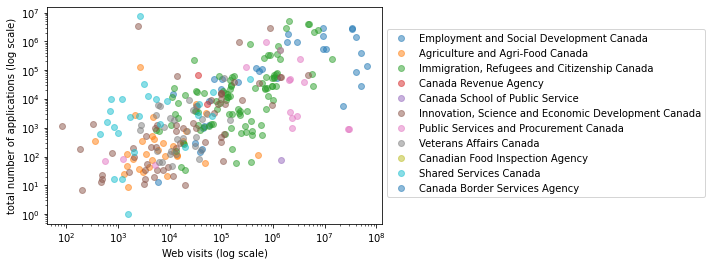

In [144]:
#Plot

#Scatter points, by department
for dept in departments_web:
    temp_df = df_web[df_web.department_name_en == dept]
    plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.total_applications, label=dept, alpha = 0.5)

#Best fit line
    
#log scale
plt.xscale('log')
plt.yscale('log')

#Axes names
plt.xlabel('Web visits (log scale)')
plt.ylabel('total number of applications (log scale)')

plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

#### Fit line

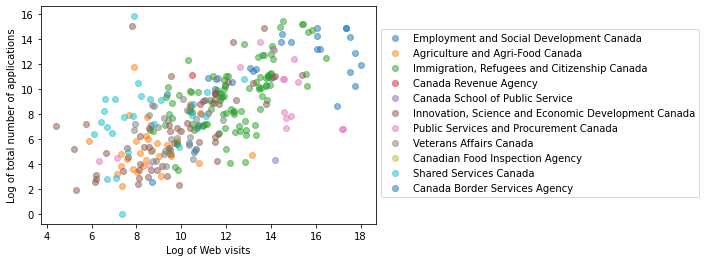

In [38]:
#Scatter points, by department
for dept in departments_web:
    temp_df = df_web[df_web.department_name_en == dept]
    x = np.log(temp_df['web_visits_info_service'].to_numpy())
    y = np.log(temp_df['total_applications'].to_numpy())
    plt.scatter(x, y, label=dept, alpha = 0.5)

#Best fit line
x = np.log(df_web['web_visits_info_service'].to_numpy())
y = np.log(df_web['total_applications'].to_numpy())

#Doesn't seem to work in Jupyter notebook, but code runs throught IDLE?
#b, m = polyfit(x, y, 1)
b = -0.28157818165988857
m = 0.7457384759300293

#Plot line
x1 = np.array([x.min(), x.max()])
plt.plot(x1, m*x1 + b)
#Why doesn't the line plot?

#Axes names
plt.xlabel('Log of Web visits')
plt.ylabel('Log of total number of applications')

plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

#### Correlation

There seems to be a linear correlation between $\log(x)$ and $\log(y)$, so we have
$$ y = e^b \cdot x^m.$$
Since $0.5 < m < 1$ this is somewhere between a square root and linear relationship. Visually, it seems to me that this is the best correlation we can find.

#### Separating by fiscal year

In [19]:
print('Web visits:')
print('min:', df_web.web_visits_info_service.min(), 'max:', df_web.web_visits_info_service.max(),'\n')
print('Total applications:')
print('min:', df_web.total_applications.min(), 'max:', df_web.total_applications.max())

Web visits:
min: 83.0 max: 65387512.0 

Total applications:
min: 1.0 max: 57653256.0


Plot for fiscal year 2016-2017


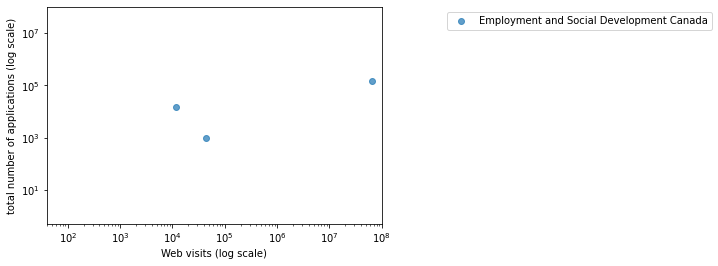

Plot for fiscal year 2017-2018


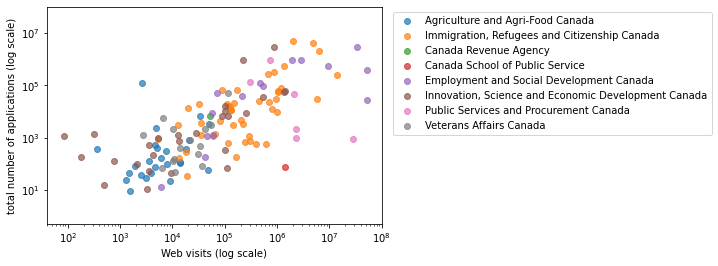

Plot for fiscal year 2018-2019


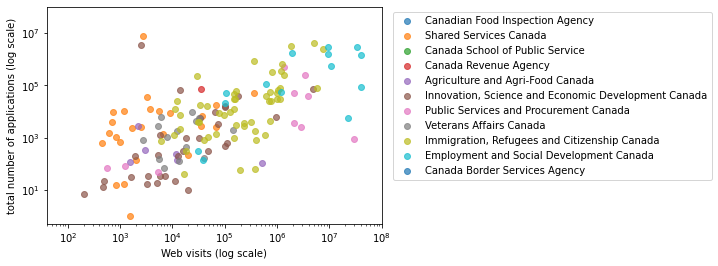

In [20]:
for year in df_web.fiscal_yr.unique():
    print('Plot for fiscal year', year)
    df_web_cur = df_web[df_web.fiscal_yr == year]
    
    #Data is currently available for the following department
    departments_web_cur = df_web_cur.department_name_en.unique()
    
    #Plot
    for dept in departments_web_cur:
        temp_df = df_web_cur[df_web_cur.department_name_en == dept]
        plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.total_applications, label=dept, alpha = 0.7)
    
    #Log scale for visibility
    plt.xscale('log')
    plt.yscale('log')
    
    #Axis range for consistency
    ax = plt.gca()
    ax.set_xlim([40, 10e7])
    ax.set_ylim([0.5, 10e7])
    
    #Axis names
    plt.xlabel('Web visits (log scale)')
    plt.ylabel('total number of applications (log scale)')
    plt.legend(bbox_to_anchor=(2, 1))
    plt.show()

### Online applications

In [21]:
#We remove rows with no online applications
df_online = df_web[df_web.online_applications != 0]

#Departments for which we have data are
departments_online = df_online.department_name_en.unique()

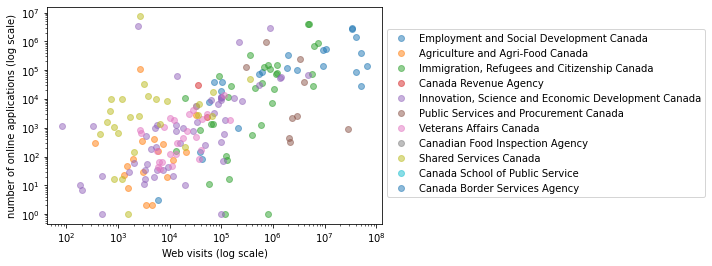

In [146]:
#plot
for dept in departments_online:
    temp_df = df_online[df_online.department_name_en == dept]
    plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.online_applications, label=dept, alpha = 0.5)

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Web visits (log scale)')
plt.ylabel('number of online applications (log scale)')
plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

#### Separating by fiscal year

In [23]:
print('Web visits:')
print('min:', df_online.web_visits_info_service.min(), 'max:', df_online.web_visits_info_service.max(),'\n')
print('Online applications:')
print('min:', df_online.online_applications.min(), 'max:', df_online.online_applications.max())

Web visits:
min: 83.0 max: 65387512.0 

Online applications:
min: 1.0 max: 33920362.0


Plot for fiscal year 2016-2017


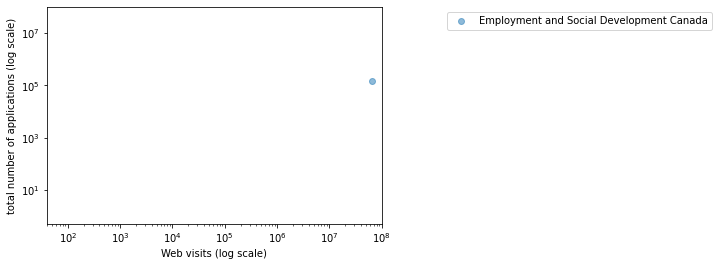

Plot for fiscal year 2017-2018


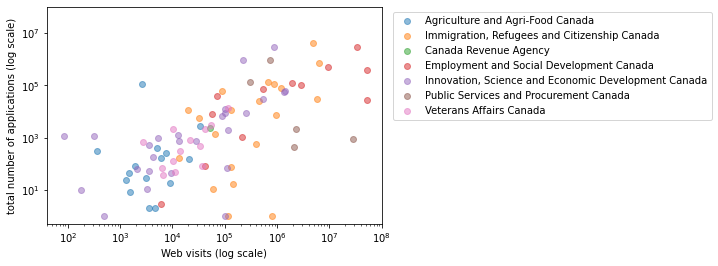

Plot for fiscal year 2018-2019


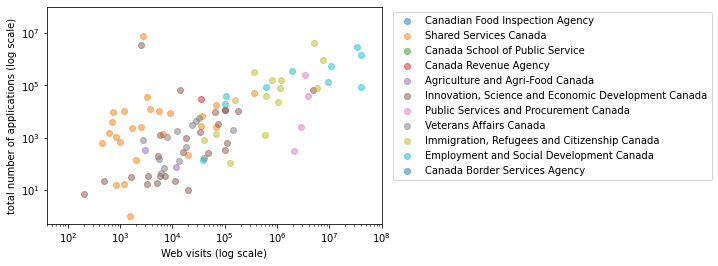

In [24]:
for year in df_online.fiscal_yr.unique():
    print('Plot for fiscal year', year)
    df_online_cur = df_online[df_online.fiscal_yr == year]
    
    #Data is currently available for the following department
    departments_online_cur = df_online_cur.department_name_en.unique()
    
    #Plot
    for dept in departments_online_cur:
        temp_df = df_online_cur[df_online_cur.department_name_en == dept]
        plt.scatter(x = temp_df.web_visits_info_service, y = temp_df.online_applications, label=dept, alpha = 0.5)
    
    #Log scale for visibility
    plt.xscale('log')
    plt.yscale('log')
    
    #Axis range for consistency
    ax = plt.gca()
    ax.set_xlim([40, 10e7])
    ax.set_ylim([0.5, 10e7])
    
    #Names and legend
    plt.xlabel('Web visits (log scale)')
    plt.ylabel('total number of applications (log scale)')
    plt.legend(bbox_to_anchor=(2, 1))
    plt.show()

## Calls received and applications

In [25]:
#Selecting important columns
df_calls = df[['fiscal_yr', 'department_name_en', 'calls_received', 'online_applications', 'total_applications']]

#Remove rows where web_visits_info_service or total_applications are null
df_calls = df_calls[(df_calls.calls_received != 0) & (df_calls.total_applications != 0)]

#Head
df_calls.head()

,fiscal_yr,department_name_en,calls_received,online_applications,total_applications
7,2016-2017,Agriculture and Agri-Food Canada,1700.0,2945.0,2945.0
14,2016-2017,Agriculture and Agri-Food Canada,40.0,320.0,320.0
19,2016-2017,Agriculture and Agri-Food Canada,620.0,620.0,725.0
22,2016-2017,Agriculture and Agri-Food Canada,10.0,7256.0,7326.0
50,2016-2017,Canada Border Services Agency,31209.0,0.0,57751821.0


In [26]:
#Remaining departments
departments_calls = df_calls.department_name_en.unique()

### Total applications

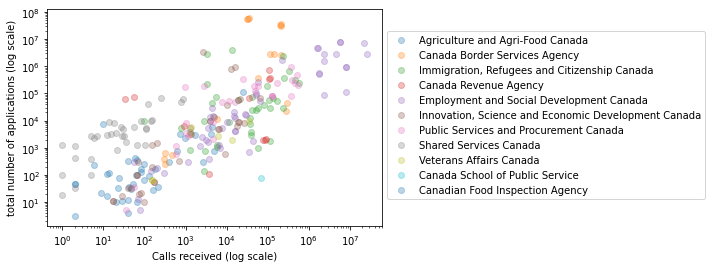

In [27]:
#plot
for dept in departments_calls:
    temp_df = df_calls[df_calls.department_name_en == dept]
    plt.scatter(x = temp_df.calls_received, y = temp_df.total_applications, label=dept, alpha = 0.3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Calls received (log scale)')
plt.ylabel('total number of applications (log scale)')
plt.legend(bbox_to_anchor=(1, 0.92))
plt.show()

#### Separating by fiscal year

In [28]:
print('Calls received:')
print('min:', df_calls.calls_received.min(), 'max:', df_calls.calls_received.max(),'\n')
print('Total applications:')
print('min:', df_calls.total_applications.min(), 'max:', df_calls.total_applications.max())

Calls received:
min: 1.0 max: 25586963.0 

Total applications:
min: 1.0 max: 58438508.0


Plot for fiscal year 2016-2017


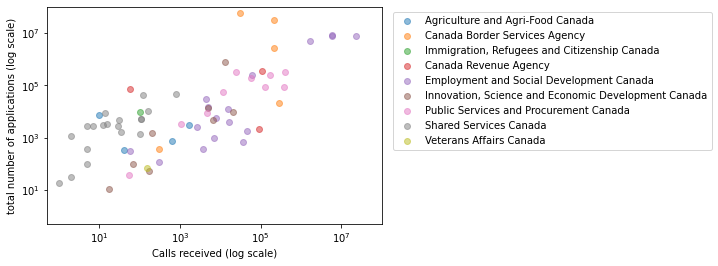

Plot for fiscal year 2017-2018


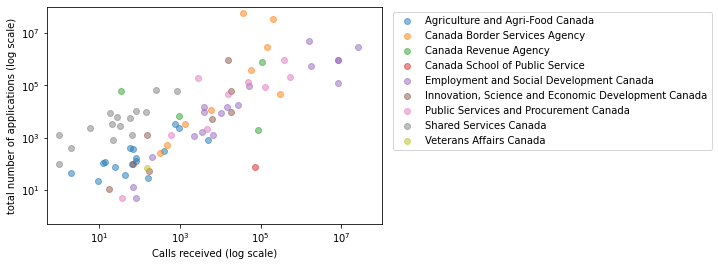

Plot for fiscal year 2018-2019


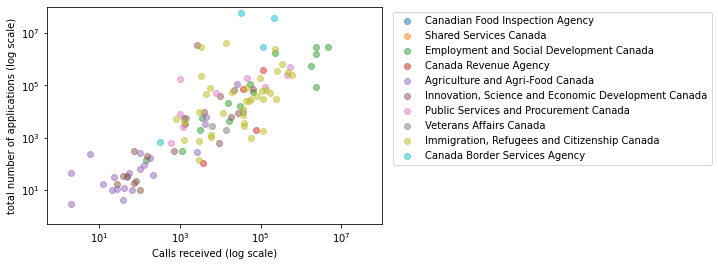

In [29]:
for year in df_calls.fiscal_yr.unique():
    print('Plot for fiscal year', year)
    df_calls_cur = df_calls[df_calls.fiscal_yr == year]
    
    #Data is currently available for the following department
    departments_calls_cur = df_calls_cur.department_name_en.unique()
    
    #Plot
    for dept in departments_calls_cur:
        temp_df = df_calls_cur[df_calls_cur.department_name_en == dept]
        plt.scatter(x = temp_df.calls_received, y = temp_df.total_applications, label=dept, alpha = 0.5)
    
    #Log scale for visibility
    plt.xscale('log')
    plt.yscale('log')
    
    #Axis range for consistency
    ax = plt.gca()
    ax.set_xlim([0.5, 10e7])
    ax.set_ylim([0.5, 10e7])
    
    #Axis names
    plt.xlabel('Calls received (log scale)')
    plt.ylabel('total number of applications (log scale)')
    plt.legend(bbox_to_anchor=(2, 1))
    plt.show()

In [31]:
#df_web_gr = df_web.groupby('department_name_en').agg('sum')
#df_web_gr

#df_web_gr.plot()
#plt.xticks(rotation = 90)
#plt.show()

#df_web_gr.plot(kind='scatter',x='web_visits_info_service',y='online_applications')
#plt.show()

# Merge Experiment

Merged all departments together to 

1. show a way to do that with quatitative data and 
2. play arund with plotting multiple bar charts

Inclduing it here just so people can be see. May delete later. 

In [37]:
df_inv_apps_data = df[['fiscal_yr','department_name_en', 'online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications', 'total_applications']]
df_inv_apps_data.head()

,fiscal_yr,department_name_en,online_applications,in_person_applications,postal_mail_applications,other_applications,total_applications
0,2016-2017,Agriculture and Agri-Food Canada,282.0,0.0,0.0,0.0,282.0
1,2016-2017,Agriculture and Agri-Food Canada,16.0,0.0,0.0,0.0,16.0
2,2016-2017,Agriculture and Agri-Food Canada,141.0,0.0,0.0,0.0,141.0
3,2016-2017,Agriculture and Agri-Food Canada,29.0,0.0,0.0,0.0,29.0
4,2016-2017,Agriculture and Agri-Food Canada,36.0,0.0,0.0,0.0,36.0


In [38]:
#del df_inv_apps_data['department_name_en']

In [39]:
#column_list=['online_applications', 'in_person_applications', 'postal_mail_applications', 'other_applications']
#df_inv_apps_data["total_applications"]=df_inv_apps_data[column_list].sum(axis=1)

In [40]:
df_inv_apps_data_merge=df_inv_apps_data.groupby('fiscal_yr').agg(sum)
df_inv_apps_data_merge.head()

,online_applications,in_person_applications,postal_mail_applications,other_applications,total_applications
fiscal_yr,,,,,
2016-2017,478579219.0,125849035.0,74259072.0,5862.0,678693188.0
2017-2018,440649111.0,119139223.0,25571726.0,4870600.0,590230660.0
2018-2019,152912414.0,118033163.0,41274701.0,3977781.0,316198059.0


We include a small plot which shows that there has been a significant increase in the number of web visits for the department of Employment and Social Development Canada.
This trend was first observed by Aaron's plot.

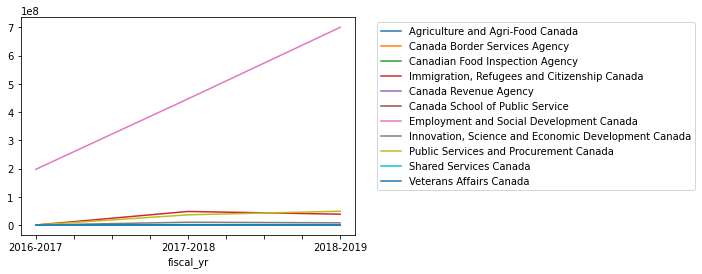

In [126]:
for dept in df.department_name_en.unique():
    df_inv[df_inv.department_name_en == dept].groupby('fiscal_yr')['web_visits_info_service'].sum().plot(label=dept)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

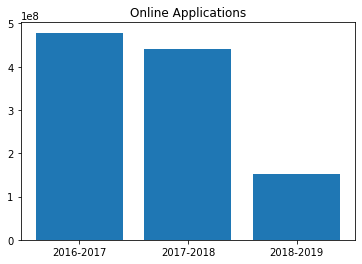

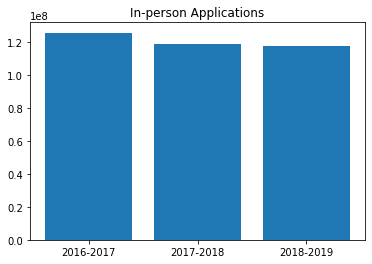

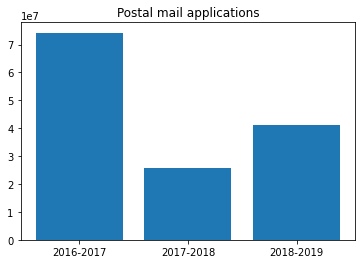

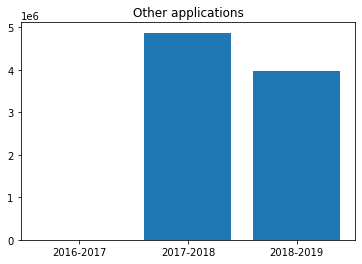

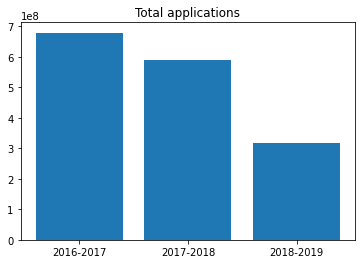

In [41]:
fig1, ax1=plt.subplots()

ax1.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.online_applications, label='online applications')
ax1.set_title("Online Applications")
fig2,ax2=plt.subplots()
ax2.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.in_person_applications)
ax2.set_title('In-person Applications')

fig3, ax3=plt.subplots()
ax3.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.postal_mail_applications)
ax3.set_title("Postal mail applications")

fig4, ax4=plt.subplots()
ax4.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.other_applications)
ax4.set_title("Other applications")

fig5, ax5=plt.subplots()
ax5.bar(df_inv_apps_data_merge.index, df_inv_apps_data_merge.total_applications)
ax5.set_title("Total applications")

plt.show()

## By Fiscal year

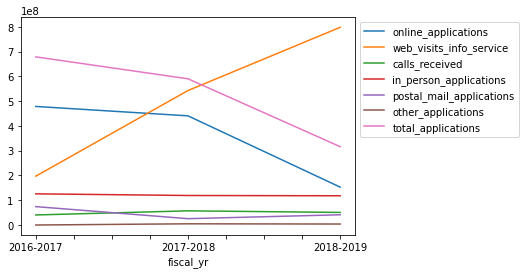

In [37]:
df.groupby('fiscal_yr').sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


With logarithmic y-axis


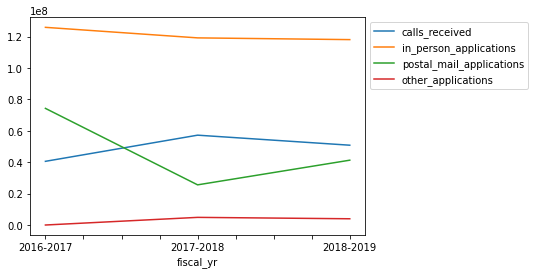

In [39]:
##Zoom in by removing web visits, total applications and online applications
options = ['calls_received', 'in_person_applications', 'postal_mail_applications', 'other_applications']

df.groupby('fiscal_yr')[options].sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

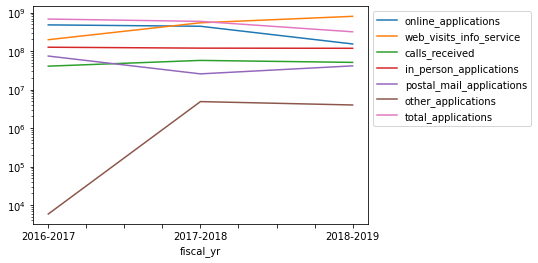

In [46]:
#Alternatively, we can try a log-scaling the y axis
df.groupby('fiscal_yr').sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.show()

## External_Internal

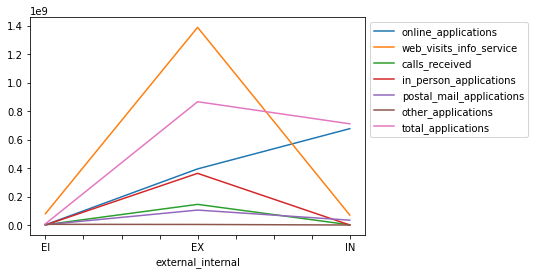


With logarithmic y-axis


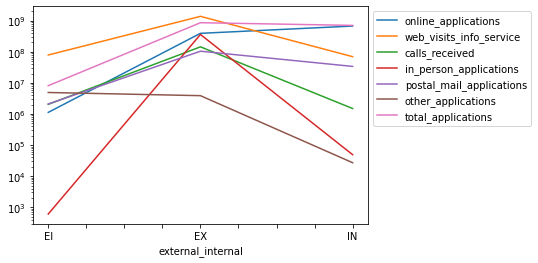

In [47]:
df.groupby('external_internal').sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

##Log scale
print('\nWith logarithmic y-axis')
df.groupby('external_internal').sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.show()

## Service Fee

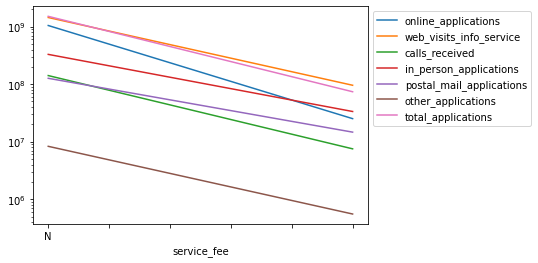

In [49]:
df.groupby('service_fee').sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.show()

## Use of Social Insurance Number

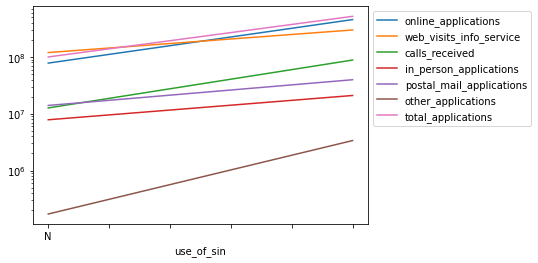

In [50]:
df.groupby('use_of_sin').sum().plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.show()

## e_


e_registration


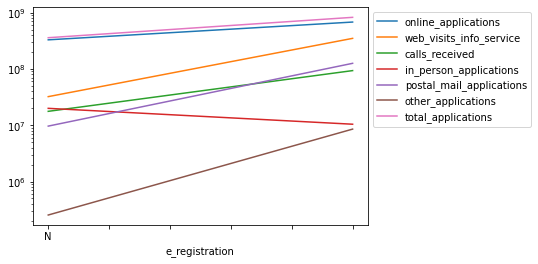


e_authentication


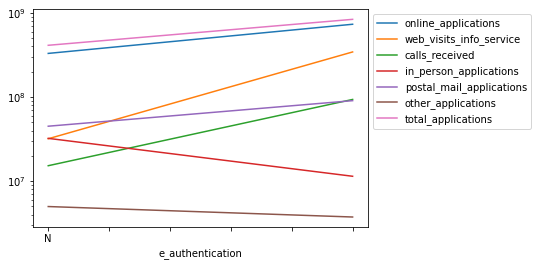


e_application


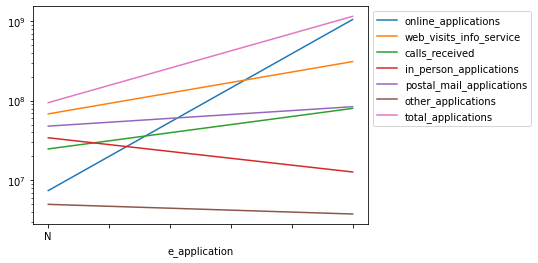


e_decision


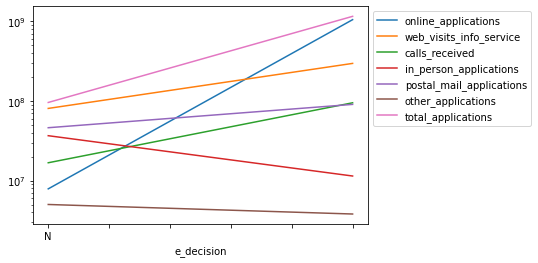


e_issuance


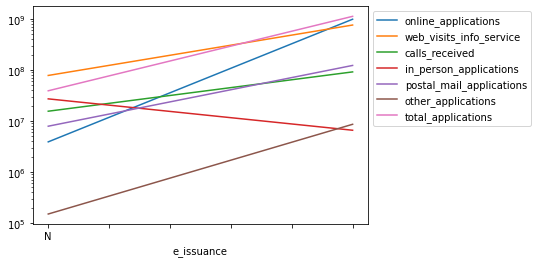


e_feedback


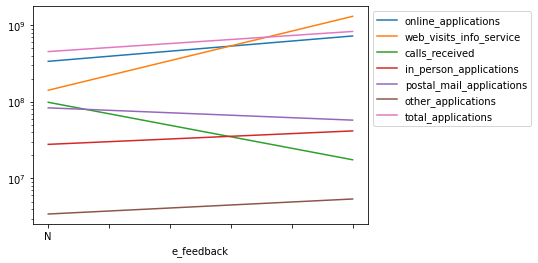

In [51]:
e_groups = ['e_registration', 'e_authentication', 'e_application', 'e_decision', 'e_issuance', 'e_feedback']

for e_el in e_groups:
    print('\n' + e_el)
    df.groupby(e_el).sum().plot()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.yscale('log')
    plt.show()

# Data distribution

We graph the distributions of web visits, the total number of applications as well and calls received. We also provide some statistical data such as the mean and the quartiles.
As one can see, the data is somewhat scewed (a plot might demostrate that better). Therefore, in order to plot the distribution, we will cutoff data.

In [121]:
for col in columns_web_total_calls:
    print('summary for', col)
    print(df[col][df[col] > 0].shape)
    print('less than 1e7:', df[col][(df[col] > 0)& (df[col] < 1e7)].shape)
    print('less than 1e6:', df[col][(df[col] > 0)& (df[col] < 1e6)].shape)

summary for web_visits_info_service
(346,)
less than 1e7: (330,)
less than 1e6: (287,)
summary for total_applications
(831,)
less than 1e7: (810,)
less than 1e6: (757,)
summary for calls_received
(287,)
less than 1e7: (284,)
less than 1e6: (266,)


In [108]:
columns_web_total_calls = ['web_visits_info_service', 'total_applications', 'calls_received']

for col in columns_web_total_calls:
    ## Note that we remove zeroes
    print('Statistical summary of ' + col)
    print(df[col][(df[col] != 0)& (df[col] < 1e6)].describe(), '\n')

Statistical summary of web_visits_info_service
count       287.000000
mean     118569.041812
std      215043.183354
min          83.000000
25%        5337.000000
50%       19796.000000
75%      110799.500000
max      989535.000000
Name: web_visits_info_service, dtype: float64 

Statistical summary of total_applications
count       757.000000
mean      44789.121532
std      127119.187610
min           1.000000
25%         201.000000
50%        2656.000000
75%       17531.000000
max      972981.000000
Name: total_applications, dtype: float64 

Statistical summary of calls_received
count       266.000000
mean      43693.657895
std      101559.642071
min           1.000000
25%          83.000000
50%        2730.500000
75%       35063.000000
max      586702.000000
Name: calls_received, dtype: float64 




Distribution of web_visits_info_service


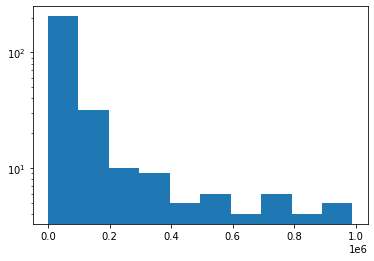


Distribution of total_applications


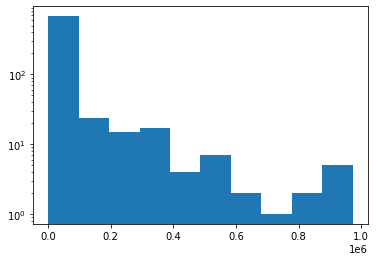


Distribution of calls_received


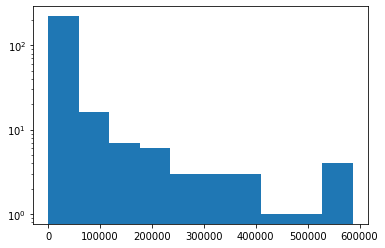

In [123]:
#Bar plot, in log scale
for col in columns_web_total_calls:
    print('\nDistribution of', col)
    plt.hist(df[col][(df[col] > 0) & (df[col] < 1e6)])
    plt.yscale('log')
    plt.show()

Density more or less a multiple of $e^{1/x}$?

# Can we make some predictions?

## Service Fee

Given the the number of web vists, number of calls received and whether a social insurance number is needed, can we predict if there is a service fee?

In [ ]:
from sklearn.linear_model import LogisticRegression



## Applications
Given the number of web site visits, calls received and data such as the fiscal year, use of social insurance numbers and use of a service fee, can we predict the nuber of applications a service will receive?